# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Diseño Acelerado de Fármacos Agonistas de la Hormona GLP-1**

### Avance 2: Ingeniería de características

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dra. Eduviges Ludivina Facundo Flores  – Profesor Tutor

### **Asesores**
- Dr. Juan Arturo Nolazco Flores
- Dr. Carlos Alberto Brizuela Rodríguez

#### **Miembros del equipo:**
- Cesar Ivan Herrera Martinez A01796392  
- Juan Antonio Cruz Acosta A01795375 
- Julio Baltazar Colín A01794476 

# Ingenieria de características

#### Configuración del ambiente

## Analisis de secuencias de péptidos

### Analisis de diversidad en las secuencias

#### Carga de los datos del EDA

In [1]:
# carga de archivos y librerias

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import sys
import os
# Análisis de propiedades fisicoquímicas de las secuencias después de CD-HIT
from iFeatureOmega import iFeatureOmegaCLI

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib


In [2]:
from pathlib import Path

# ruta del directorio del notebook actual
notebook_dir = Path.cwd()

# Subir un nivel para llegar a la carpeta raíz del proyecto
project_root = notebook_dir.parent

# Añadir la carpeta raíz al path de Python
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"Ruta del proyecto añadida al path: {project_root}")

from src.bio_utils import save_df_as_fasta, fasta_to_dataframe, inspect_fasta_file, calculate_identity_matrix
from src.plotting import identity_heatmap, cumulative_variance_plot, plot_pca_2d

Ruta del proyecto añadida al path: d:\source\Proyecto Integrador\glp-1_drug_discovery


In [3]:
# Ruta los archivos de datos
directorio_base = Path("../")
directorio_datos = Path(directorio_base / "data")
raw_data_dir = directorio_datos / "raw"
processed_data_dir = directorio_datos / "processed"
ruta_125_ec50= directorio_datos/raw_data_dir/ "125_EC50.csv"

# Ruta archivos procesados

# Ruta archivo FASTA filtrado
ruta_fasta_glp1_sec_activa= processed_data_dir / "GLP-1_Activo.fasta"

# Ruta archivo CSV con péptidos GLP-1 identificados
ruta_csv_glp_identificados= processed_data_dir / "glucagon_like_peptides.csv"

# Ruta archivo CSV con péptidos  con actividad EC50
ruta_125_ec50= directorio_datos/raw_data_dir/ "125_EC50.csv"

# Ruta archivo FASTA con péptidos  con actividad EC50
ruta_fasta_125_ec50= processed_data_dir / "125_EC50.fasta"


In [4]:
# carga de datos fasta de la proteina GLP-1R
load_gpl1_fasta_results = inspect_fasta_file(ruta_fasta_glp1_sec_activa)

if load_gpl1_fasta_results and load_gpl1_fasta_results['is_valid']:
    print(f"'{ruta_fasta_glp1_sec_activa}' es válido.")
    print(f"Se encontraron {load_gpl1_fasta_results['record_count']} registros válidos.")

df_glp1_sec_activa = fasta_to_dataframe(ruta_fasta_glp1_sec_activa)
print(f"Dimensiones del DataFrame: {df_glp1_sec_activa.shape}")

Inspecting file: ..\data\processed\GLP-1_Activo.fasta...
  - OK! File is structurally valid. Found 897 records.
'..\data\processed\GLP-1_Activo.fasta' es válido.
Se encontraron 897 registros válidos.
Dimensiones del DataFrame: (897, 3)


In [5]:
df_glp1_sec_activa

,id,description,sequence
0,AF-A0A060VXS0-F1,AF-A0A060VXS0-F1,HAEGTYTSDMSSYLQDQAAKEFVSWLKNGR
1,AF-A0A060VY52-F1,AF-A0A060VY52-F1,HAEGTYTSDVSSYLQDQAAKEFVSWLKNGR
2,AF-A0A060WDT4-F1,AF-A0A060WDT4-F1,HADGTYTSDVSTYLQDQAAKDFVSWLKSGL
3,AF-A0A087VEU7-F1,AF-A0A087VEU7-F1,HAEGTYTSDITSYLEGQAAKEFIAWLVNGR
4,AF-A0A087XPV4-F1,AF-A0A087XPV4-F1,HADGTFTSDVSSYLKDQAIKDFVAQLKSGQ
...,...,...,...
892,tr|A0A8C9ICK2|A0A8C9ICK2_9PRIM,tr|A0A8C9ICK2|A0A8C9ICK2_9PRIM,HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR
893,tr|A0A8I3QXE0|A0A8I3QXE0_CANLF,tr|A0A8I3QXE0|A0A8I3QXE0_CANLF,HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR
894,tr|F7ID40|F7ID40_CALJA,tr|F7ID40|F7ID40_CALJA,HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR
895,tr|G1TRR9|G1TRR9_RABIT,tr|G1TRR9|G1TRR9_RABIT,HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR


In [6]:
# carga de datos csv de los peptidos GLP-1 identificados y con actividad EC50
try:
    df_glp1_identificados = pd.read_csv(ruta_csv_glp_identificados)
    print(f"Archivo '{ruta_csv_glp_identificados}' cargado correctamente.")
    print(f"Dimensiones del DataFrame: {df_glp1_identificados.shape}")
except FileNotFoundError:
    print(f"Error: El archivo '{ruta_csv_glp_identificados}' no se encontró.")

Archivo '..\data\processed\glucagon_like_peptides.csv' cargado correctamente.
Dimensiones del DataFrame: (897, 34)


In [7]:
# carga de datos csv de los peptidos con actividad EC50 para entrenar el modelo
try:
    df_125_ec50 = pd.read_csv(ruta_125_ec50)
    print(f"Archivo '{ruta_125_ec50}' cargado correctamente.")
    print(f"Dimensiones del DataFrame: {df_125_ec50.shape}")
except FileNotFoundError:
    print(f"Error: El archivo '{ruta_125_ec50}' no se encontró.")

Archivo '..\data\..\data\raw\125_EC50.csv' cargado correctamente.
Dimensiones del DataFrame: (125, 9)


In [8]:
df_125_ec50

,Unnamed: 0,pep_ID,alias,sequence,length,EC50_T1,EC50_LOG_T1,EC50_T2,EC50_LOG_T2
0,1,seq_pep1,training_data,HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE,30,3.75,-11.43,563.00,-9.25
1,2,seq_pep2,training_data,HSQGTFTSDYSKYLDSRRAEDFVQWLENGE,30,18.50,-10.73,552.00,-9.26
2,3,seq_pep3,training_data,HSQGTFTSDYSKYLDSRRAEDFVQWLENT,29,3.51,-11.45,252.00,-9.60
3,4,seq_pep4,training_data,HSQGTFTSDYSKYLDSRRAEDFVQWLVAGGSGSGSG,36,50.50,-10.30,6.03,-11.22
4,5,seq_pep5,training_data,HSQGTFTSDYSKYLDSRRAQDFVQWLEAEG,30,2.87,-11.54,238.00,-9.62
...,...,...,...,...,...,...,...,...,...
120,121,seq_pep121,training_data,HGEGTFTSDVSSYMERQSVDEFIAWLLKGR,30,29000.00,-7.54,9.62,-11.02
121,122,seq_pep122,training_data,HGEGTFTSDVSSYMESQLVDEFIAWLLKGR,30,29400.00,-7.53,7.94,-11.10
122,123,seq_pep123,training_data,HGEGTFTSDVSSYMEPQSTDEFIAWLLKGR,30,29500.00,-7.53,29500.00,-7.53
123,124,seq_pep124,training_data,HGEGTFTSDVSSYMDFQSLVEFLAWLLKGR,30,29200.00,-7.53,598.00,-9.22


In [9]:
#conversión de archivos de 125 peptidos a fasta para el calculo de propiedades

dt_temp = df_125_ec50.copy()
dt_temp['Fasta_Header'] = df_125_ec50['Fasta_Header'] = df_125_ec50['pep_ID'] + ' ' +'EC50_T2'+ ' '+ df_125_ec50['EC50_T2'].astype(str)

save_df_as_fasta(
    dataframe=dt_temp,
    id_col='Fasta_Header',
    seq_col='sequence',
    output_file=ruta_fasta_125_ec50
    
)

results = inspect_fasta_file(Path(ruta_fasta_125_ec50))

if results and results['is_valid']:
    print(f"'{ruta_fasta_125_ec50}' es válido.")
    print(f"Se encontraron {results['record_count']} registros válidos.")
else:
    print(f"\nLa validación falló para '{ruta_fasta_125_ec50}'. Por favor, revisa los registros.")

del dt_temp, results

Success! DataFrame has been saved to '..\data\processed\125_EC50.fasta'.
Inspecting file: ..\data\processed\125_EC50.fasta...
  - OK! File is structurally valid. Found 125 records.
'..\data\processed\125_EC50.fasta' es válido.
Se encontraron 125 registros válidos.


## Agrupación de secuencias biológicas CD-Hit

### CD-HIT
CD-Hit es una herramienta bioinformática ampliamente utilizada para agrupar secuencias biológicas, como proteínas o ácidos nucleicos, en función de su similitud. Su objetivo principal es reducir la redundancia en grandes conjuntos de datos de secuencias, facilitando el análisis y la interpretación de la información genética o proteica.
se utiliza un algoritmo de clustering rápido y eficiente que agrupa secuencias similares basándose en un umbral de identidad definido por el usuario. Las secuencias que superan este umbral se agrupan en un solo clúster, representado por una secuencia representativa, mientras que las secuencias que no cumplen con el criterio permanecen como secuencias individuales.  
Permite a los investigadores identificar familias de secuencias relacionadas, estudiar la diversidad genética, y optimizar bases de datos de secuencias para análisis posteriores, como la anotación funcional o la predicción estructural. CD-Hit es especialmente útil en estudios de genómica, proteómica y metagenómica, donde se manejan grandes volúmenes de datos secuenciales.

In [10]:
# Ruta archivo fasta con resultados de CD-HIT
cd_hit_results_fasta = processed_data_dir / "cd-hit_results.fasta"

In [11]:
## Conversión de rutas de Windows a WSL
import subprocess
from pathlib import Path

def convert_to_wsl_path(windows_path: str) -> str:
    """
    Convierte una ruta de Windows a su equivalente en WSL usando 'wslpath'.
    
    Args:
        windows_path (str): La ruta en formato Windows (e.g., "C:\\Users\\...").

    Returns:
        str: La ruta en formato WSL (e.g., "/mnt/c/Users/...").
    """
    # Ejecuta 'wslpath -u' para convertir la ruta
    result = subprocess.run(["wsl", "wslpath", "-u", windows_path], capture_output=True, text=True, check=True)
    # .strip() elimina cualquier espacio o nueva línea al final
    return result.stdout.strip()


In [12]:
# Ejecutar CD-HIT en WSL con rutas convertidas
#  Define tus rutas en Windows usando pathlib
#    .resolve() las convierte en rutas absolutas, lo cual es útil para evitar problemas con rutas relativas
input_fasta_win = Path(ruta_fasta_glp1_sec_activa).resolve()
output_cdhit_win = Path(cd_hit_results_fasta).resolve()

try:
    # 2. Convierte las rutas de Windows a formato WSL
    input_fasta_wsl = convert_to_wsl_path(str(input_fasta_win))
    output_cdhit_wsl = convert_to_wsl_path(str(output_cdhit_win))

    print(f"Ruta de Windows (entrada): {input_fasta_win}")
    print(f"Ruta de WSL (entrada):    {input_fasta_wsl}")
    print("-" * 20)
    print(f"Ruta de Windows (salida): {output_cdhit_win}")
    print(f"Ruta de WSL (salida):     {output_cdhit_wsl}")
    print("-" * 20)

    # 3. Construye el comando final con las rutas ya convertidas
    command = [
        "wsl", 
        "cd-hit", 
        "-i", input_fasta_wsl, 
        "-o", output_cdhit_wsl, 
        "-c", "0.99",
        "-T", "4"  # Usa 4 hilos (ajusta según tu CPU)
    ]

    # 4. Ejecuta el comando
    print("Ejecutando comando en WSL...")
    return_status = subprocess.run(command, capture_output=True, text=True)

    # Imprime la salida y los errores para depuración
    print(return_status.stdout)
    
    if return_status.returncode == 0:
        print("\nComando ejecutado exitosamente.")
    else:
        print(f"\nEl comando falló con código de error: {return_status.returncode}")
        print("\n--- ERRORES (STDERR) ---")
        print(return_status.stderr)
        
except FileNotFoundError:
    print("Error: Asegúrate de que WSL y/o 'cd-hit' estén instalados y en el PATH del sistema.")
except subprocess.CalledProcessError as e:
    print(f"Error al convertir una ruta con wslpath: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

Ruta de Windows (entrada): D:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\GLP-1_Activo.fasta
Ruta de WSL (entrada):    /mnt/d/source/Proyecto Integrador/glp-1_drug_discovery/data/processed/GLP-1_Activo.fasta
--------------------
Ruta de Windows (salida): D:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\cd-hit_results.fasta
Ruta de WSL (salida):     /mnt/d/source/Proyecto Integrador/glp-1_drug_discovery/data/processed/cd-hit_results.fasta
--------------------
Ejecutando comando en WSL...
Program: CD-HIT, V4.8.1 (+OpenMP), Sep 17 2025, 17:21:22
Command: cd-hit -i
         /mnt/d/source/Proyecto Integrador/glp-1_drug_discovery/data/processed/GLP-1_Activo.fasta
         -o
         /mnt/d/source/Proyecto Integrador/glp-1_drug_discovery/data/processed/cd-hit_results.fasta
         -c 0.99 -T 4

Started: Sat Oct  4 19:42:10 2025
                            Output                              
----------------------------------------------------------------

In [13]:
# carga de datos fasta del resultado de cd-hit
load_cdhit_fasta_results = inspect_fasta_file(cd_hit_results_fasta)

if load_cdhit_fasta_results and load_cdhit_fasta_results['is_valid']:
    print(f"'{cd_hit_results_fasta}' es válido.")
    print(f"Se encontraron {load_cdhit_fasta_results['record_count']} registros válidos.")

df_cdhit = fasta_to_dataframe(cd_hit_results_fasta)
print(f"Dimensiones del DataFrame: {df_cdhit.shape}")

Inspecting file: ..\data\processed\cd-hit_results.fasta...
  - OK! File is structurally valid. Found 225 records.
'..\data\processed\cd-hit_results.fasta' es válido.
Se encontraron 225 registros válidos.
Dimensiones del DataFrame: (225, 3)


### Analisis de diversidad de las secuencias

Calculando matriz de identidad ANTES de CD-HIT...


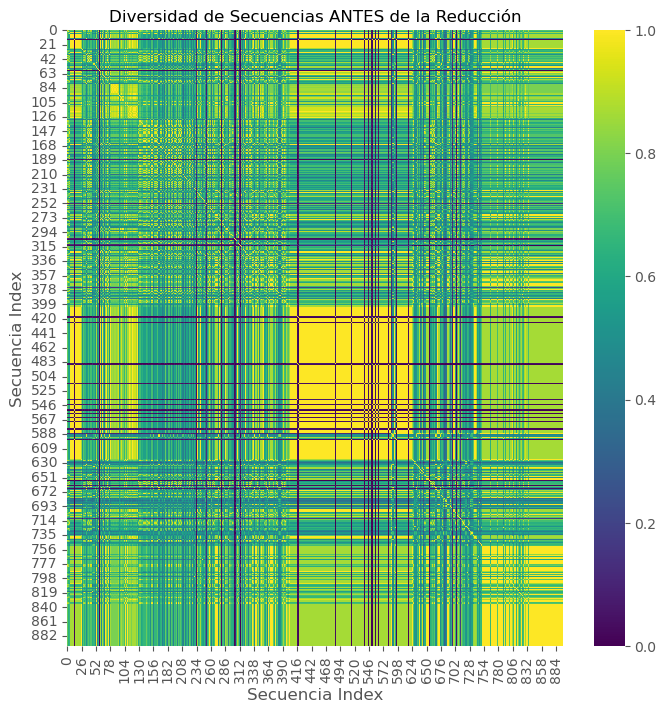

In [14]:
# Mapa de calor de la matriz de identidad antes de CD-HIT
# 1. Extraer la lista de secuencias
sequences_before = df_glp1_sec_activa['sequence'].tolist()

# 2. Calcular la matriz
print("Calculando matriz de identidad ANTES de CD-HIT...")
identity_matrix_before = calculate_identity_matrix(sequences_before)

# 3. Visualizar el mapa de calor
identity_heatmap(identity_matrix_before, 'Diversidad de Secuencias ANTES de la Reducción')

Calculando matriz de identidad DESPUÉS de CD-HIT...


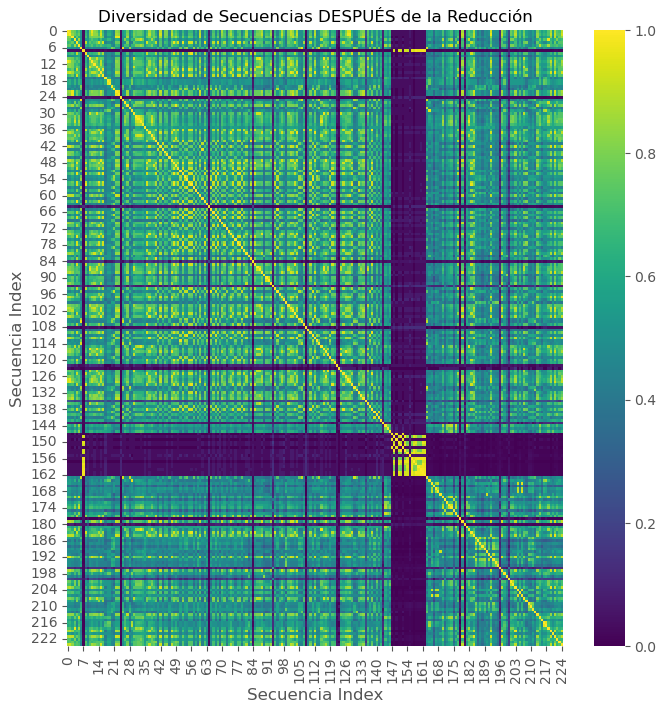

In [15]:
# Mapa de calor de la matriz de identidad después de CD-HIT
# 1. Extraer la lista de secuencias
sequences_after = df_cdhit['sequence'].tolist()

# 2. Calcular la matriz
print("Calculando matriz de identidad DESPUÉS de CD-HIT...")
identity_matrix_after = calculate_identity_matrix(sequences_after)

# 3. Visualizar el mapa de calor
identity_heatmap(identity_matrix_after, 'Diversidad de Secuencias DESPUÉS de la Reducción')

## Cálculo de propiedades Físico - químicas

In [16]:
# cargar las configuraciónes
ifeatures_settings_json = Path(directorio_datos / "iFeature Settings" / "Protein_parameters_setting.json") 

### Definímos funciones auxiliares para calcular los descriptores

In [17]:
# Funcion para el calculo de descriptor

def compute_single_descriptor(input_fasta_file, descriptor, settings_json_file=None):
    """
    Calcula un descriptor con iFeatureOmega y devuelve un DataFrame indexado por ID.

    Parámetros
    ----------
    input_fasta_file : str
        Ruta al archivo FASTA o TXT con secuencias.
    descriptor : str
        Nombre del descriptor (por ejemplo, "AAC", "DPC", "CTDC").
    settings_json_file : str | None
        Ruta al archivo JSON de configuración de parámetros.

    Retorna
    -------
    pandas.DataFrame
        DataFrame con las secuencias como índice y columnas prefijadas con el descriptor.
    """
    print(f"Calculando descriptor: {descriptor}")

    protein = iFeatureOmegaCLI.iProtein(input_fasta_file)

    if settings_json_file:
        try:
            protein.import_parameters(settings_json_file)
        except Exception as e:
            print(f"No se pudo importar parámetros: {e}")

    try:
        protein.get_descriptor(descriptor)
    except Exception as e:
        print(f"Error al calcular {descriptor}: {e}")
        return None

    df = protein.encodings.reset_index()

    if df.empty:
         print(f"Descriptor {descriptor} no generó resultados.")
         return None

    # # Normalizar el nombre de la columna ID y ponerla como índice
    df.rename(columns={df.columns[0]: "ID"}, inplace=True)
    df = df.set_index("ID")
    return df


In [18]:
# Funcion para el calculo de varios descriptores usando una lista
def compute_peptide_features(input_fasta_file, descriptors, settings_json_file, output_csv=None):
    """
    Calcula descriptores relevantes con iFeatureOmega y devuelve un DataFrame.
    """
    if not descriptors or not isinstance(descriptors, (list, tuple)):
        raise ValueError("Se necesita una lista no vacía de descriptores.")

    results = []
    for desc in descriptors:
        df = compute_single_descriptor(input_fasta_file, desc, settings_json_file)
        if df is not None:
            results.append((desc, df))

    if not results:
        raise Exception("No se pudieron calcular descriptores válidos.")

    combined = results[0][1]
    for desc, df in results[1:]:
        combined = combined.merge(df, left_index=True, right_index=True, how="inner")

    combined.reset_index(inplace=True)

    if output_csv:
        combined.to_csv(output_csv, index=False)
        print(f"Resultados guardados en {output_csv}")

    expected_ids = results[0][1].index
    for desc, df in results[1:]:
        lost = set(expected_ids) - set(df.index)
        if lost:
            print(f"En el descriptor {desc} faltaron {len(lost)} secuencias: {list(lost)[:3]}...")

    return combined


### Calculamos los descriptores de los peptidos usando iFeature

In [19]:
# Definimos una lista de descriptores
descriptores = [
            "AAC",      # Amino Acid Composition
            "DPC type 1",      # Dipeptide Composition
            "CTDC",     # Composition descriptor of CTD
            "CTDT",     # Transition descriptor
            "CTDD",     # Distribution descriptor
            "PAAC",     # Pseudo amino acid composition
            "APAAC",    # Amphiphilic pseudo amino acid comp.
            "SOCNumber",# Sequence-order-coupling number
            "QSOrder",   # Quasi-sequence-order
        ]

In [20]:
# Calculamos los descriptores
df_descriptores_cdhit = compute_peptide_features(cd_hit_results_fasta, descriptores, ifeatures_settings_json)

Calculando descriptor: AAC
File imported successfully.
Calculando descriptor: DPC type 1
File imported successfully.
Calculando descriptor: CTDC
File imported successfully.
Calculando descriptor: CTDT
File imported successfully.
Calculando descriptor: CTDD
File imported successfully.
Calculando descriptor: PAAC
File imported successfully.
Calculando descriptor: APAAC
File imported successfully.
Calculando descriptor: SOCNumber
File imported successfully.
Calculando descriptor: QSOrder
File imported successfully.


In [21]:
df_descriptores_cdhit

,ID,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,...,QSOrder_Grantham.Xr.T,QSOrder_Grantham.Xr.W,QSOrder_Grantham.Xr.Y,QSOrder_Grantham.Xr.V,QSOrder_Schneider.Xd.1,QSOrder_Schneider.Xd.2,QSOrder_Schneider.Xd.3,QSOrder_Grantham.Xd.1,QSOrder_Grantham.Xd.2,QSOrder_Grantham.Xd.3
0,AF-A0A060VXS0-F1,0.100000,0.0,0.066667,0.066667,0.033333,0.066667,0.033333,0.000000,0.066667,...,0.000044,0.000022,0.000044,0.000022,0.211439,0.226593,0.193363,0.305946,0.398305,0.295727
1,AF-A0A060VY52-F1,0.100000,0.0,0.066667,0.066667,0.033333,0.066667,0.033333,0.000000,0.066667,...,0.000044,0.000022,0.000044,0.000044,0.210518,0.224985,0.194083,0.303795,0.396899,0.299284
2,AF-A0A060WDT4-F1,0.100000,0.0,0.133333,0.000000,0.033333,0.066667,0.033333,0.000000,0.066667,...,0.000063,0.000021,0.000042,0.000042,0.200063,0.213188,0.210418,0.307237,0.384096,0.308647
3,AF-A0A087VEU7-F1,0.133333,0.0,0.033333,0.100000,0.033333,0.100000,0.033333,0.066667,0.033333,...,0.000072,0.000024,0.000048,0.000024,0.202669,0.208992,0.207828,0.325355,0.370518,0.304103
4,AF-A0A087XPV4-F1,0.100000,0.0,0.133333,0.000000,0.066667,0.066667,0.033333,0.033333,0.100000,...,0.000042,0.000000,0.000021,0.000042,0.186085,0.225168,0.221368,0.297677,0.382796,0.319506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,XP_027996892.1,0.133333,0.0,0.033333,0.166667,0.066667,0.033333,0.033333,0.000000,0.000000,...,0.000045,0.000022,0.000022,0.000089,0.214635,0.216648,0.190567,0.304351,0.373305,0.322322
221,XP_028292477.1,0.100000,0.0,0.133333,0.000000,0.033333,0.066667,0.033333,0.000000,0.066667,...,0.000065,0.000022,0.000043,0.000043,0.209197,0.225149,0.193405,0.315583,0.392402,0.291993
222,XP_029460758.1,0.100000,0.0,0.033333,0.166667,0.033333,0.100000,0.033333,0.033333,0.066667,...,0.000045,0.000023,0.000045,0.000045,0.222086,0.220614,0.193801,0.313850,0.371506,0.314621
223,XP_030211526.1,0.166667,0.0,0.100000,0.066667,0.066667,0.066667,0.033333,0.000000,0.066667,...,0.000044,0.000022,0.000022,0.000044,0.186947,0.223201,0.218683,0.298643,0.363206,0.338128


In [22]:
### calculamos las propiedades fisico quimicas para el conjunto de 125 Peptidos con actividad EC50

df_descriptores_125p = compute_peptide_features(ruta_fasta_125_ec50, descriptores, ifeatures_settings_json)

Calculando descriptor: AAC
File imported successfully.
Calculando descriptor: DPC type 1
File imported successfully.
Calculando descriptor: CTDC
File imported successfully.
Calculando descriptor: CTDT
File imported successfully.
Calculando descriptor: CTDD
File imported successfully.
Calculando descriptor: PAAC
File imported successfully.
Calculando descriptor: APAAC
File imported successfully.
Calculando descriptor: SOCNumber
File imported successfully.
Calculando descriptor: QSOrder
File imported successfully.


In [23]:
df_descriptores_125p

,ID,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,...,QSOrder_Grantham.Xr.T,QSOrder_Grantham.Xr.W,QSOrder_Grantham.Xr.Y,QSOrder_Grantham.Xr.V,QSOrder_Schneider.Xd.1,QSOrder_Schneider.Xd.2,QSOrder_Schneider.Xd.3,QSOrder_Grantham.Xd.1,QSOrder_Grantham.Xd.2,QSOrder_Grantham.Xd.3
0,seq_pep1,0.033333,0.0,0.100000,0.100000,0.066667,0.066667,0.033333,0.000000,0.033333,...,0.000045,0.000023,0.000045,0.000023,0.242596,0.243376,0.148768,0.332017,0.389247,0.278714
1,seq_pep2,0.033333,0.0,0.100000,0.100000,0.066667,0.066667,0.033333,0.000000,0.033333,...,0.000044,0.000022,0.000044,0.000022,0.240487,0.248035,0.142783,0.322224,0.392330,0.285424
2,seq_pep3,0.034483,0.0,0.103448,0.068966,0.068966,0.034483,0.034483,0.000000,0.034483,...,0.000068,0.000023,0.000045,0.000023,0.233972,0.240618,0.143956,0.319652,0.397344,0.282981
3,seq_pep4,0.055556,0.0,0.083333,0.027778,0.055556,0.166667,0.027778,0.000000,0.027778,...,0.000044,0.000022,0.000044,0.000044,0.222942,0.231500,0.150119,0.311165,0.366846,0.321967
4,seq_pep5,0.066667,0.0,0.100000,0.066667,0.066667,0.066667,0.033333,0.000000,0.033333,...,0.000045,0.000022,0.000045,0.000022,0.254242,0.221244,0.159753,0.344734,0.368942,0.286301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,seq_pep121,0.033333,0.0,0.066667,0.100000,0.066667,0.100000,0.033333,0.033333,0.033333,...,0.000048,0.000024,0.000024,0.000048,0.208610,0.207909,0.221706,0.340393,0.368338,0.291245
121,seq_pep122,0.033333,0.0,0.066667,0.100000,0.066667,0.100000,0.033333,0.033333,0.033333,...,0.000043,0.000022,0.000022,0.000043,0.218421,0.195141,0.211252,0.307243,0.380062,0.312674
122,seq_pep123,0.033333,0.0,0.066667,0.100000,0.066667,0.100000,0.033333,0.033333,0.033333,...,0.000075,0.000025,0.000025,0.000025,0.218196,0.186828,0.210458,0.333322,0.353846,0.312807
123,seq_pep124,0.033333,0.0,0.066667,0.066667,0.100000,0.100000,0.033333,0.000000,0.033333,...,0.000047,0.000024,0.000024,0.000047,0.243621,0.178736,0.179768,0.389474,0.373542,0.236960


### Guardamos la informacion en formato csv para el analisis y posterior carga

In [24]:
df_resultado = pd.merge(
    left=df_descriptores_125p,         
    right=df_125_ec50[['pep_ID', 'EC50_T2']], 
    left_on='ID',                      
    right_on='pep_ID',                 
    how='left'                        
)

df_descriptores_125p = df_resultado.drop('pep_ID', axis=1)
df_descriptores_125p['ID'] = df_descriptores_125p['ID'].astype("string")
df_descriptores_125p['EC50_T2'] = df_descriptores_125p['EC50_T2'].astype("float64")

In [25]:
descriptores_125_csv = processed_data_dir/"descriptores_125.csv"
descriptores_cdhit_csv = processed_data_dir/"descriptores_cdhit.csv"

In [26]:
### Guardado de resultados

df_descriptores_125p.to_csv(descriptores_125_csv, index=False)   
df_descriptores_cdhit.to_csv(descriptores_cdhit_csv, index=False)   

## Analisis ce Componentes Principales PCA

Se aplicara la transformación de PCA para visualizar los componentes principales de las caracteristicas elegidas.

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [28]:
# Separación de los dato de la columna objetivo y el identificador
features = df_descriptores_125p.drop(columns=['ID', 'EC50_T2'])
target = df_descriptores_125p['EC50_T2']
ids = df_descriptores_125p['ID']

In [29]:
# Aplicación de el escalado de características
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

### Calculamos PCA con solo dos componentes para visualizar

In [30]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
final_df = pd.concat([pca_df, target], axis=1)

In [31]:
final_df

,PC1,PC2,EC50_T2
0,-4.529496,14.397514,563.00
1,-3.603736,14.336233,552.00
2,-3.271943,16.137186,252.00
3,11.331718,7.155883,6.03
4,-3.796093,13.535745,238.00
...,...,...,...
120,-8.481907,-1.272076,9.62
121,-8.249616,-1.735785,7.94
122,-5.300969,-2.010609,29500.00
123,-8.419926,-0.836219,598.00


## Graficamos los 2 componentes principales para detectar clusters

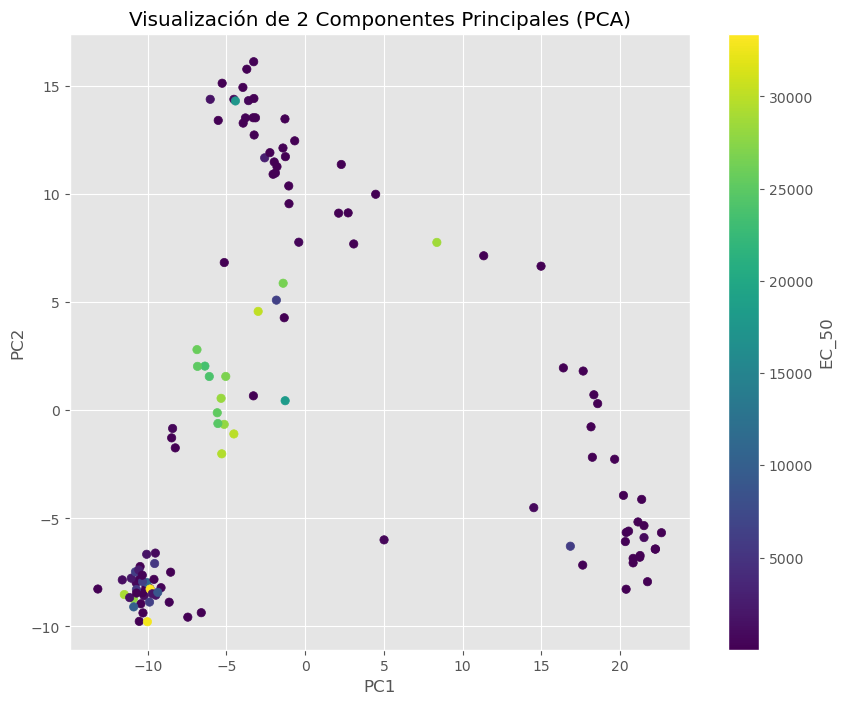

In [32]:
plot_pca_2d(final_df, color_by=final_df['EC50_T2'],label = "EC_50")

### Cálulo de la varianza acumulada

In [33]:
# Calculo de PCA con todos los componentes
# Se deja PCA() vacío para que calcule todos los componentes posibles
pca = PCA()
pca.fit(features_scaled)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


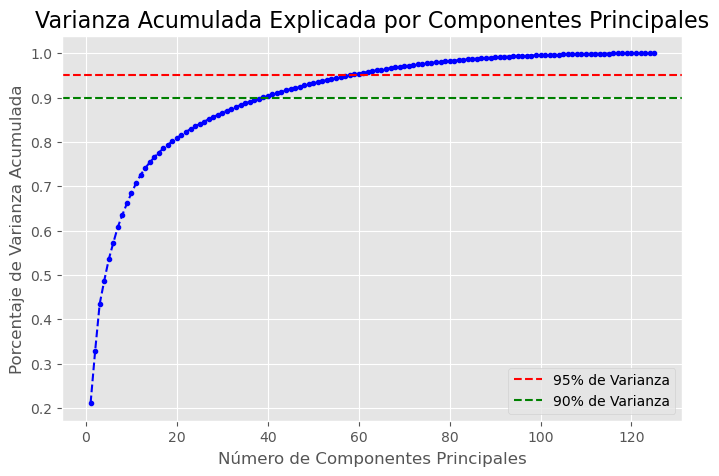

In [34]:
# Calcular la varianza acumulada
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
cumulative_variance_plot(cumulative_variance)

### Cálculo de PCA con los datos obtenidos de CD-HIT

In [35]:
# Separación de los dato de la columna objetivo y el identificador
features = df_descriptores_cdhit.drop(columns=['ID'])

# Aplicación de el escalado de características
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
final_df = pd.concat([pca_df, target], axis=1)

In [36]:
final_df

,PC1,PC2,EC50_T2
0,3.500707,-6.353175,563.00
1,4.085036,-7.784418,552.00
2,5.327651,-7.648142,252.00
3,6.098971,-4.777371,6.03
4,3.384373,-5.880008,238.00
...,...,...,...
220,4.865357,3.897691,NaN
221,5.187882,-8.674234,NaN
222,4.277794,-3.312175,NaN
223,4.981462,-6.173942,NaN


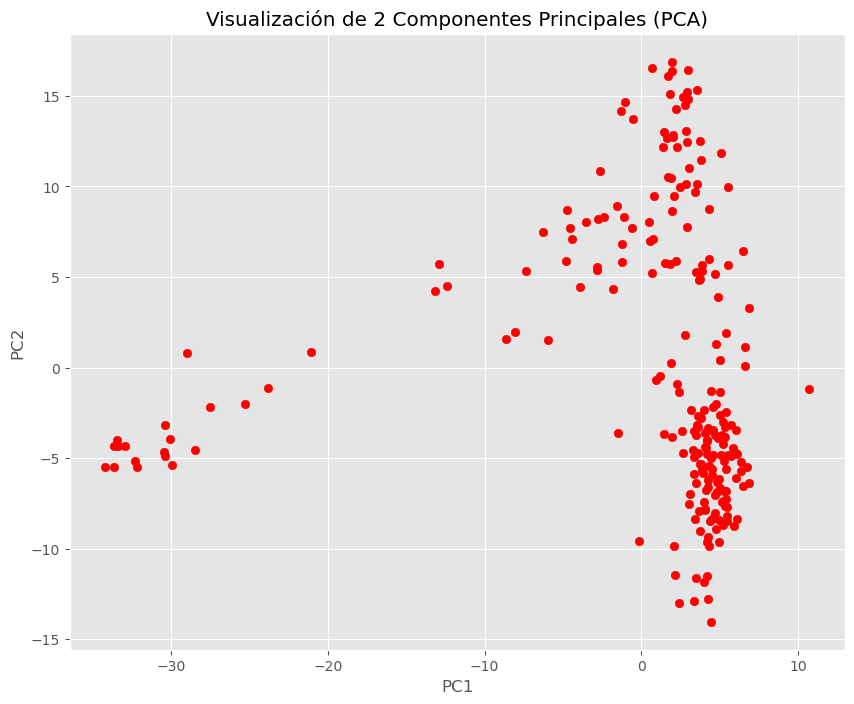

In [40]:
plot_pca_2d(final_df)

In [38]:
# Calculo de PCA con todos los componentes
# Se deja PCA() vacío para que calcule todos los componentes posibles
pca = PCA()
pca.fit(features_scaled)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


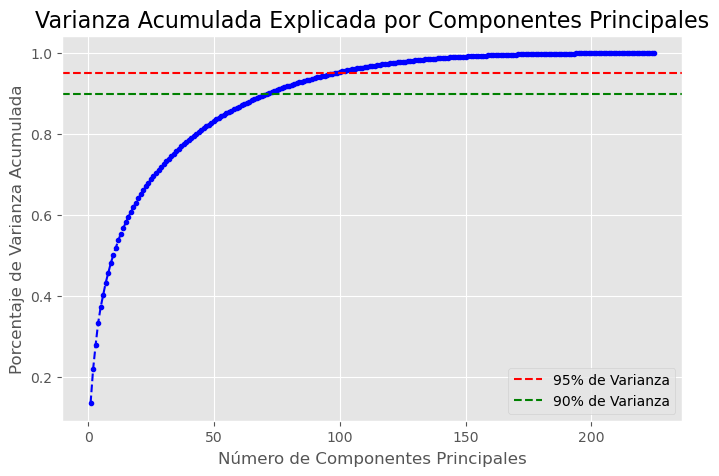

In [41]:
# Calcular la varianza acumulada
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
cumulative_variance_plot(cumulative_variance)

## Conclusiones

## Referencias